**1. Load The Data**

Keras comes with a library called datasets, which we can use to load datasets out of the box.

In [0]:
import matplotlib.pyplot as plt 
from keras.datasets import fashion_mnist
from keras.layers import Input,Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model,Sequential
from keras.optimizers import RMSprop



In [0]:
(train_X, train_Y),(test_X, test_Y) = fashion_mnist.load_data()

Note that for this task, we don’t need training labels and testing labels. Our training images will both act as the input as well as the ground truth similar to the labels we have in classification task.

**2. Data Exploration**

We shall first analyse how images in the dataset look like. Even though we know the dimension of the images by now, it is still worth the effort to analyze its programmatically, we might have to rescale the image pixels and resize the image:

In [0]:
print("Training set (images) shape :{shape}".format(shape=train_X.shape))
print("Test set (images) shape :{shape}".format(shape=test_X.shape) )

Training set (images) shape :(60000, 28, 28)
Test set (images) shape :(10000, 28, 28)


From the above output, we can see that the training data has shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimensions. Let’s create a dictionary that will have class names with their corresponding categorical class labels:

In [0]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneake',
 8: 'Bag',
 9: 'Ankle Boot',
}

We will take a look a look at what the images in our dataset:

Text(0.5, 1.0, 'Ground Truth : 2')

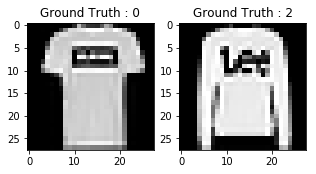

In [0]:
plt.figure(figsize=[5,5])
 
plt.subplot(121)
plt.imshow(train_X[1,:,:],cmap='gray')
plt.title('Ground Truth : {}'.format(train_Y[1]))
 
plt.subplot(122)
plt.imshow(test_X[1,:,:],cmap='gray')
plt.title('Ground Truth : {}'.format(test_Y[1]))

**3. Data Preprocessing**

The images of the dataset are indeed grayscale images with pixel values ranging from 0 to 255 with a dimension of 28 x 28 so before we feed the data into the model it is very important to preprocess it. We will first convert each 28 x 28 image of train and test test set into a matrix of size 28 x 28 x 1, which we can feed into the network:

In [0]:
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

The data right now is in an int8 format, so before we feed it into the network we need to convert it type to float32, and we also have to rescale the pixel values in range 0-1 inclusive.

In [0]:
train_X = train_X.astype('float32')/255.
test_X = test_X.astype('float32')/255.

After all of this , it’s import to partition the data. In order for our model to generalize well, we split the training data into two parts: a training and a validation set. We will train our model on 80& of the data and validate in on 20% of the remaining training data.

In [0]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_X,
                                                                train_X,
                                                               test_size=0.2,
                                                               random_state=13)

Now we are all set to define the network and feed the data into the network!

**4. The Convolutional Autoencoder**

The images are of size 28 x 28 x 1 or a 784-dimensional vector. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it’s of size 28 x 28 x 1, and feed this as an input to the network.

Also, you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system you train your model. It contributes heavily in determining the learning parameters and affects the prediction accuracy. You will train your network for 50 epochs

In [0]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape=(x,y,inChannel))
 

As discussed before, the autoencoder is divided into two parts: encoder and decoder.

Encoder

 

*      The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer
*       The second layer will have 64 filters of size 3 x 3, followed by a another downsampling layer
*       The final layer of encoder will have 128 filters of size 3 x 3

Decoder


*       The first layer will have 128 filters of size 3 x 3, followed by a upsampling layer
*       The second layer will have 64 filters of size 3 x 3, followed by a another upsampling layer
*       The final layer of encoder will have 1filters of size 3 x 3

Let’s define the model.

In [0]:
def autoencoder(input_img):
  # encoder
  conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_img) # 28 x 28 x 32
  pool1 = MaxPooling2D(pool_size=(2,2))(conv1) # 14 x 14 x 32
  conv2 = Conv2D(64, (3,3), activation='relu', padding='same')(pool1)# 14 x 14 x 64
  pool2 = MaxPooling2D(pool_size=(2,2))(conv2) # 7 x 7 x 64
  conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(pool2) # 7 x 7 x 128
  
  
  # decoder
  conv4 = Conv2D(128, (3,3), activation='relu', padding='same')(conv3) # 7 x 7 x 128
  up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
  conv5 = Conv2D(64, (3,3), activation='relu', padding='same')(up1)# 14 x 14 x 64
  up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
  
  return decoded

In [0]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error',optimizer=RMSprop())

we can visualize the architecture of our model!

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 128)         147584    
__________

It’s finally time to train the model with Keras’ fit() function! The model trains for 50 epochs. The fit() function will return a history object; By storing the result of this function in fashion_train, we can use it later to plot the loss function plot between training and validation which will help you to analyze your model’s performance visually.

In [0]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50


We can now visualize the result by plotting them!

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally, we can see that the validation loss and the training loss both are in sync. It shows that our model is not overfitting: the validation loss is decreasing and not increasing, and there rarely any gap between training and validation loss.

Therefore, we can say that our model’s generalization capability is good.

Finally, it’s time to reconstruct the test images using the predict() function of Keras and see how well our model is able reconstruct on the test data.

**5. Predicting on Test Data**

We will be predicting the trained model on the complete 10,000 test images and plot few of the reconstructed images to visualize how well our model is able to reconstruct the test images.

In [0]:
pred = autoencoder.predict(test_X)
 
plt.figure(figsize=(20,4))
print("Test images")
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(test_X[i,...,0],cmap='gray')
  curr_lbl = test_Y[i]
  plt.title("(Label: "+str(label_dict[curr_lbl]) + ")")
  
plt.show()
plt.figure(figsize=(20,4))
print("Reconstruct of Test images")
for i in range(10):
  plt.subplot(2,10,i+1)
  plt.imshow(pred[i,...,0],cmap='gray')
plt.show()

From the above figures, we can observe that your model did a fantastic job in reconstructing the test images that you predicted using the model. At least visually speaking, the test and the reconstructed images look almost exactly similar.